In [1]:
import pandas as pd
import numpy as np

par_par   = ['PAR', 'EHD', 'WAARDE']
point_par = ['LOC', 'PLT:X', 'PLT:Y', 'DATUM:TIJD']

# TODO restrict columns.
df = pd.read_csv("../data/intermediate/rest.csv", parse_dates=['DATUM:TIJD'],
                 usecols=par_par + point_par + ['CPM'])

In [2]:
group_gen = iter(df.groupby(['LOC', 'PLT:X', 'PLT:Y']))

for loc, cdf in group_gen:
    if 50 in cdf.CPM.unique() and 80 in cdf.CPM.unique():
        break
    else:
        print(*cdf.CPM.unique())

print(loc)

10 80
10 80
10 80
50
('AMSDM', 12221600, 48821000)


In [3]:
par_desc = df.groupby(['PAR', 'EHD', 'CPM'])[['WAARDE']].describe()
par_desc = par_desc[~par_desc.WAARDE['std'].isna() &
                    (par_desc.WAARDE['std'] > 0) & (par_desc.WAARDE['count'] > 2000)]

same_point = df.groupby(['LOC', 'PLT:X', 'PLT:Y', 'DATUM:TIJD'])

cnt = len(par_desc.index)
par_i = {par:i for i,par in enumerate(par_desc.index.sort_values())}
i_par = {par_i[k]:k for k in par_i}

cnt

371

Verzamelt verschillende sommen, waarmee correlatie berekend kan worden.

In [96]:
cov_sums = [[(0,0,0,0,0,0) for i in range(cnt)] for j in range(cnt)]

n = 0
for point, cdf in same_point:
    n = n + 1
    if n==10 or n==100 or n%1000 == 0: print(n, "of ~18000")  # TODO better do it every some number of seconds.
    il = [(par_i[tuple(k)], val) for val,k in zip(cdf.WAARDE, zip(cdf.PAR, cdf.EHD, cdf.CPM)) if tuple(k) in par_i]
    for i,val1 in il:
        for j,val2 in il:
            nij, sij,si,sj,si2,sj2 = cov_sums[i][j]
            cov_sums[i][j] = (nij+1, sij + val1*val2, si + val1, sj + val2,
                              si2 + val1*val1, sj2 + val2*val2)
n

10 of ~18000
100 of ~18000
1000 of ~18000
2000 of ~18000
3000 of ~18000
4000 of ~18000
5000 of ~18000
6000 of ~18000
7000 of ~18000
8000 of ~18000
9000 of ~18000
10000 of ~18000
11000 of ~18000
12000 of ~18000
13000 of ~18000
14000 of ~18000
15000 of ~18000
16000 of ~18000
17000 of ~18000


17767

In [112]:
def feq(x,y):
    return abs(x-y)<1e-7

for i in range(cnt):
    for j in range(i,cnt):
        assert feq(cov_sums[i][j][0], cov_sums[j][i][0]), (i,j)
        assert feq(cov_sums[i][j][1], cov_sums[j][i][1]), (i,j)
        assert feq(cov_sums[i][j][2], cov_sums[j][i][3]), (i,j)
        assert feq(cov_sums[i][j][3], cov_sums[j][i][2]), (i,j)

Produceert de correlatie matrix.

In [98]:
import math

variance = [sii/n - (si/n)**2 if n>0 else 0
            for (n, sii,si,sj,si2,sj2) in (cov_sums[i][i] for i in range(cnt))]

corr = [[(sij/n - si*sj/(n*n))/math.sqrt((si2/n-(si/n)**2)*(sj2/n-(sj/n)**2))
         if (n>0 and (si2/n-(si/n)**2)*(sj2/n-(sj/n)**2)>1e-3) else 0
         for vi,vj,(n, sij,si,sj,si2,sj2) in ((variance[i],variance[j], cov_sums[i][j]) for i in range(cnt))]
        for j in range(cnt)]

In [99]:
max(map(max, corr)), min(map(min, corr))  # This iisnt right..

(1.0000000000000027, -1.0)

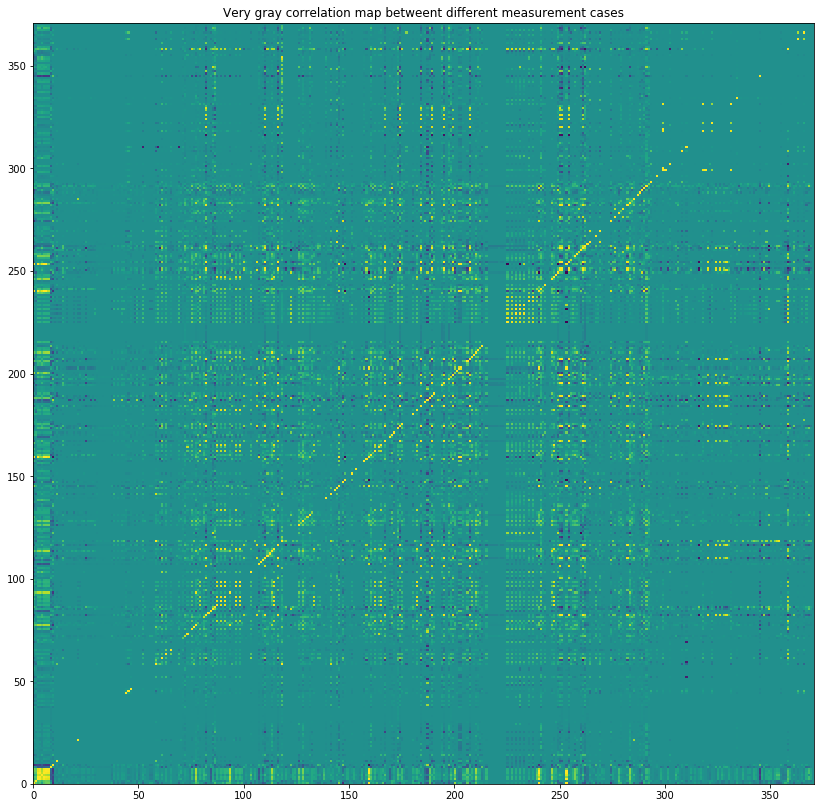

In [113]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

fig, ax = plt.subplots(figsize=(14,14))
ax.set_title("correlation map between different measurement cases")
ax.pcolor(np.array(corr))

In [106]:
import graphviz

# Graphviz voor de sterkste correlaties!
Opmerking:

1. ~~De waarden kloppen nog niet.~~
2. Zou handig zijn om de null-hypothesis kansen erbij te nemen.
3. Voorafgaant selecties in de data, en "startpunt".
4. Positief/negatief beter aangeven.

In [107]:
oms_df = pd.read_csv("../data/intermediate/oms.csv")
oms_df.drop('index', axis=1, inplace=True)

def oms_par(name):
    return next(iter(oms_df[(oms_df.type=='PAROMS') & (oms_df.name==name)].desc))

In [108]:
g = graphviz.Graph()

# Make a list with strongest(anti)correlators.
lst = [(corr[i][j], cov_sums[i][j], i,j) for i,j in
       ((math.floor(k/cnt),k%cnt) for k in range(cnt*cnt) if math.floor(k/cnt)>k%cnt)
       if cov_sums[i][j][0] > 100]

lst.sort(key=lambda e:abs(e[0]), reverse=True)

node_fmt = "{}({}, {})"
for c,cs, (par1,u1, cpm1),(par2,u2, cpm2) in ((c,cs, i_par[i],i_par[j]) for c,cs,i,j in lst[:200]):
    g.edge(node_fmt.format(oms_par(par1), u1,cpm1), node_fmt.format(oms_par(par2), u2,cpm2),
           label="{0:.{2}f}({2})".format(c,1,cs[0]))

In [111]:
g.save("all_corr_all")
g.render("all_corr_all")

'all_corr_all.pdf'

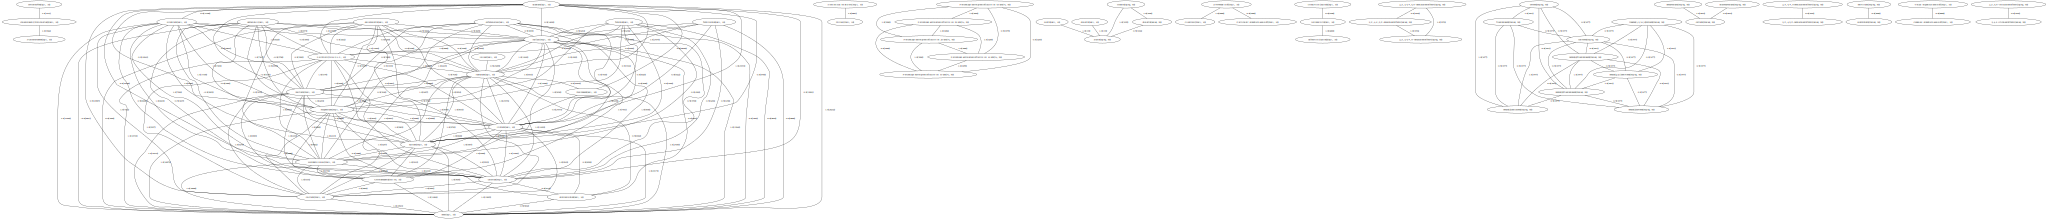

In [110]:
g

In [ ]:
par_i[('ZS', 'mg/L', 10)]

In [ ]:
g = graphviz.Graph()

# Make a list with strongest(anti)correlators.
lst = [(corr[i][j], cov_sums[i][j], i,j) for i,j in
       ((math.floor(k/cnt),k%cnt) for k in range(cnt*cnt) if math.floor(k/cnt)>k%cnt)
       if cov_sums[i][j][0] > 100]

lst.sort(key=lambda e:abs(e[0]), reverse=True)

node_fmt = "{}({}, {})"
for c,cs, (par1,u1, cpm1),(par2,u2, cpm2) in ((c,cs, i_par[i],i_par[j]) for c,cs,i,j in lst[:200]):
    g.edge(node_fmt.format(oms_par(par1), u1,cpm1), node_fmt.format(oms_par(par2), u2,cpm2),
           label="{0:.{1}f}({2})".format(c,1,cs[0]))